In [1]:
import re
import os
import sys
import json
import numpy as np
import pandas as pd
from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta

from processing import *
from model import *
from tools import *

%config InlineBackend.figure_format = 'svg'
init_setting()

(CVXPY) Apr 20 06:39:48 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 20 06:39:48 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [ ]:
df.sort_values(by='col4', key=lambda col: col.str.lower())

In [62]:
# 征信变量字典
feature_describe = pd.read_excel("common/汇总--变量匹配--202303081021.xlsx")
feature_describe = feature_describe.sort_values("变量名", key=lambda x: x.str.len(), ascending=False).drop_duplicates("变量名")
feature_map = dict(zip(feature_describe["变量名"], feature_describe["字段"]))

In [3]:
data = pd.read_csv("即科230418重跑结果154笔.csv", encoding="gbk").rename(columns={"流水号": "报告编号"})
appid = pd.read_excel("车信贷征信回溯报告20230419.xlsx")
data = data.merge(appid, on="报告编号")
data["指标"] = data["指标"].apply(json.loads)
all_features = list(data["指标"][0].keys())
data[all_features] = data["指标"].apply(lambda x: [x.get(c) for c in all_features]).apply(pd.Series)
car_loan = query_loan_info(plan=False)
data = data.merge(car_loan[["N_OVERDUE_DAYS", "N_MAX_OVERDUE_DAYS", "D_LOAN_DATE", "C_EXT_ID"]].rename(columns={"C_EXT_ID": "订单编号"}), on="订单编号", how="left")

In [4]:
dpd = 15
data["TARGET_CURRENT"] = (data["N_OVERDUE_DAYS"] > dpd).astype(int)
data["TARGET_EVER"] = (data["N_MAX_OVERDUE_DAYS"] > dpd).astype(int)
data = data[data["D_LOAN_DATE"] < (datetime.strptime("2023-04-19", "%Y-%m-%d") - relativedelta(months=1) - relativedelta(days=dpd))]

In [5]:
target="TARGET_EVER"
train = data.query(
    "(N_MAX_OVERDUE_DAYS == 0 | N_MAX_OVERDUE_DAYS > @dpd) & D_LOAN_DATE >= '2022-12-28'"
)[all_features + [target]].replace("", np.nan).drop(columns=["GEXDK_X1828_2", "GEXDK_X1828_3", "GEXreportno", "GEX_var0023", "GEXreporttime"])
# train.select_dtypes("number").fillna(-1.0, inplace=True)
train.select_dtypes("object").fillna("-1", inplace=True)
train["GEXBASE_X46_10"] = train["GEXBASE_X46_10"].astype(int)
train["GEXBASE_X46_9"] = train["GEXBASE_X46_9"].astype(int)

In [17]:
pre_select = FeatureSelection(target=target, empty=0.9, corr=0.7, iv=0.1, identical=0.9)
train_select = pre_select.fit_transform(train)

[INFO] filtering variables ...
Variable filtering on 56 rows and 562 columns in 00:00:13 
273 variables are removed


In [18]:
combiner = Combiner(target=target, min_samples=0.025, min_prebin_size=0.01, min_bin_size=0.02, n_jobs=-1, method="cart", engine="optbinning", max_n_bins=4, max_n_prebins=10, monotonic_trend="auto_asc_desc")
train_select_bins = combiner.fit_transform(train_select)

In [19]:
# transform = WOETransformer(target=target)
# train_woe = transform.fit_transform(train_select_bins)

In [20]:
# processing_select = FeatureSelection(target=target, engine="toad", empty=0.9, corr=0.5, iv=0.02)
# train_select_woe = processing_select.fit_transform(train_woe)
# train_select_woe.shape

In [21]:
# stepwise = StepwiseSelection(target=target)
# train_stepwise_woe = stepwise.fit_transform(train_select_woe)

In [22]:
init_setting()

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,LIFT值
0,GEXDK_X2520,最近12个月轻度逾期个人消费贷款账户数,"[负无穷 , 0.5)",44,0.7857,41,0.8542,3,0.3750,0.0682,0.4773
1,GEXDK_X2520,最近12个月轻度逾期个人消费贷款账户数,"[0.5 , 1.5)",8,0.1429,5,0.1042,3,0.3750,0.3750,2.6250
2,GEXDK_X2520,最近12个月轻度逾期个人消费贷款账户数,"[1.5 , 正无穷)",4,0.0714,2,0.0417,2,0.2500,0.5000,3.5000


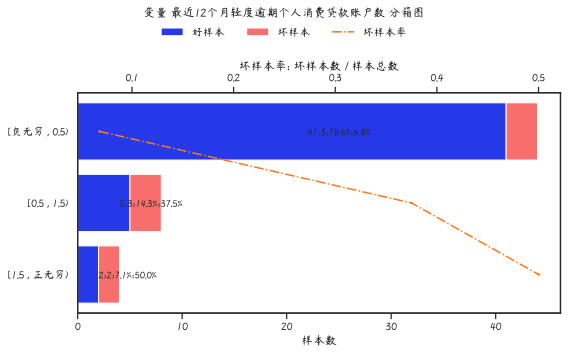

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,LIFT值
0,GEXBASE_X190,最近五年逾期透支贷记卡账户单月最长逾期透支月数,"[负无穷 , 1.5)",20,0.3571,17,0.3542,3,0.3750,0.1500,1.0500
1,GEXBASE_X190,最近五年逾期透支贷记卡账户单月最长逾期透支月数,"[1.5 , 正无穷)",4,0.0714,2,0.0417,2,0.2500,0.5000,3.5000
2,GEXBASE_X190,最近五年逾期透支贷记卡账户单月最长逾期透支月数,缺失值,32,0.5714,29,0.6042,3,0.3750,0.0938,0.6562


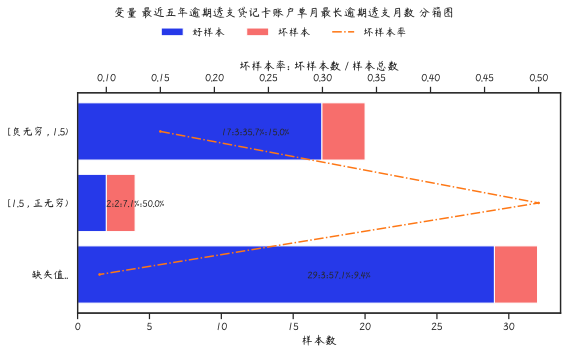

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,LIFT值
0,GEXBASE_X244,最近12个月任意连续1个月最大查询次数,"[负无穷 , 1.5)",2,0.0357,1,0.0208,1,0.1250,0.5000,3.5000
1,GEXBASE_X244,最近12个月任意连续1个月最大查询次数,"[1.5 , 正无穷)",54,0.9643,47,0.9792,7,0.8750,0.1296,0.9074


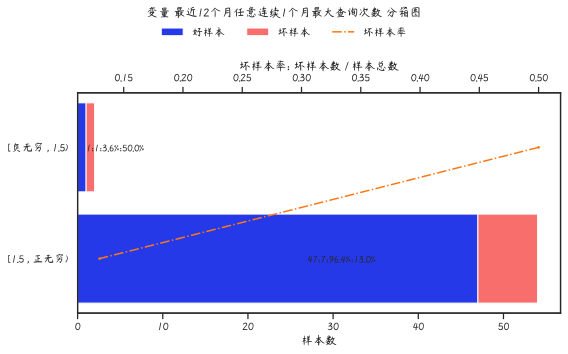

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,LIFT值
0,GEXDK_X57,现用无逾期贷款账户数量占现用贷款账户数量比率,"[负无穷 , 0.7333331406116486)",3,0.0536,1,0.0208,2,0.2500,0.6667,4.6667
1,GEXDK_X57,现用无逾期贷款账户数量占现用贷款账户数量比率,"[0.7333331406116486 , 0.8452379703521729)",5,0.0893,3,0.0625,2,0.2500,0.4000,2.8000
2,GEXDK_X57,现用无逾期贷款账户数量占现用贷款账户数量比率,"[0.8452379703521729 , 正无穷)",48,0.8571,44,0.9167,4,0.5000,0.0833,0.5833


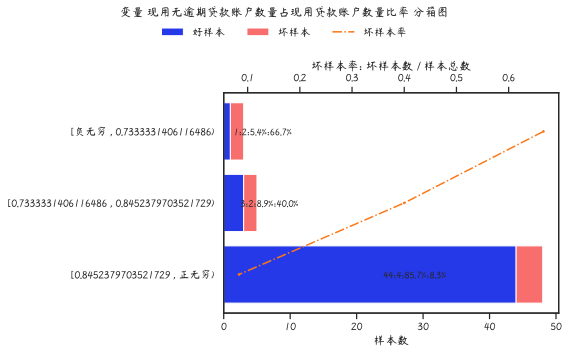

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,LIFT值
0,GEXDJK_X1350,贷记卡最近3个月逾期贷记卡的期数求和,"[负无穷 , 0.5)",47.0000,0.8393,41.0000,0.8542,6.0000,0.7500,0.1277,0.8936
1,GEXDJK_X1350,贷记卡最近3个月逾期贷记卡的期数求和,"[0.5 , 正无穷)",4.0000,0.0714,2.0000,0.0417,2.0000,0.2500,0.5000,3.5000
2,GEXDJK_X1350,贷记卡最近3个月逾期贷记卡的期数求和,缺失值,5.0000,0.0893,5.0000,0.1042,0.0000,0.0000,0.0000,0.0000


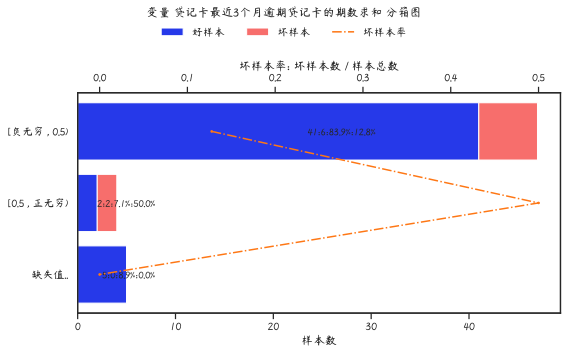

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,LIFT值
0,GEXDJK_X1643,贷记卡最近6个月最大逾期持续月份最大值,"[负无穷 , 0.5)",47.0000,0.8393,41.0000,0.8542,6.0000,0.7500,0.1277,0.8936
1,GEXDJK_X1643,贷记卡最近6个月最大逾期持续月份最大值,"[0.5 , 正无穷)",4.0000,0.0714,2.0000,0.0417,2.0000,0.2500,0.5000,3.5000
2,GEXDJK_X1643,贷记卡最近6个月最大逾期持续月份最大值,缺失值,5.0000,0.0893,5.0000,0.1042,0.0000,0.0000,0.0000,0.0000


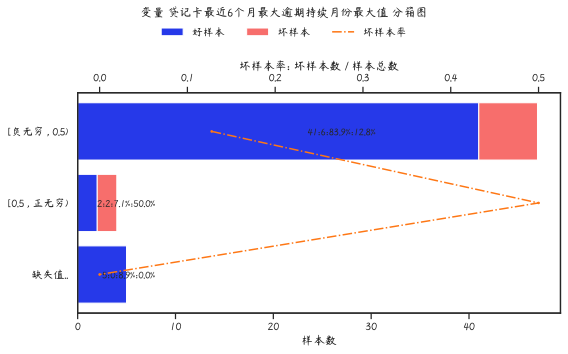

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,LIFT值
0,GEXBASE_X19,最近6个月查询次数保前审查,"[负无穷 , 2.5)",54,0.9643,47,0.9792,7,0.8750,0.1296,0.9074
1,GEXBASE_X19,最近6个月查询次数保前审查,"[2.5 , 正无穷)",2,0.0357,1,0.0208,1,0.1250,0.5000,3.5000


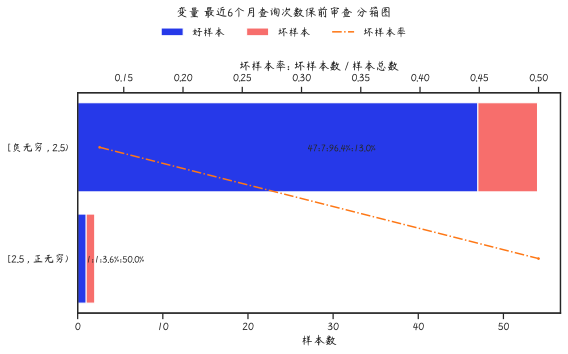

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,LIFT值
0,GEXBASE_X61,最新职业信息行业,"批发和零售业,租赁和商务服务业,-1,居民服务、修理和其他服务业",47,0.8393,42,0.8750,5,0.6250,0.1064,0.7447
1,GEXBASE_X61,最新职业信息行业,制造业,7,0.1250,5,0.1042,2,0.2500,0.2857,2.0000
2,GEXBASE_X61,最新职业信息行业,建筑业,2,0.0357,1,0.0208,1,0.1250,0.5000,3.5000


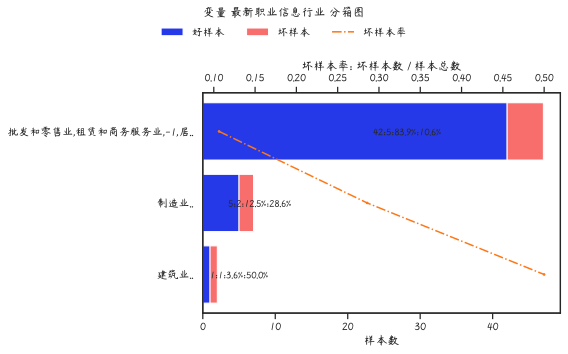

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,LIFT值
0,GEXDJK_X1826,贷记卡最近24个月最大逾期持续月份最大值,"[负无穷 , 0.5)",41.0000,0.7321,37.0000,0.7708,4.0000,0.5000,0.0976,0.6829
1,GEXDJK_X1826,贷记卡最近24个月最大逾期持续月份最大值,"[0.5 , 1.5)",8.0000,0.1429,5.0000,0.1042,3.0000,0.3750,0.3750,2.6250
2,GEXDJK_X1826,贷记卡最近24个月最大逾期持续月份最大值,"[1.5 , 正无穷)",2.0000,0.0357,1.0000,0.0208,1.0000,0.1250,0.5000,3.5000
3,GEXDJK_X1826,贷记卡最近24个月最大逾期持续月份最大值,缺失值,5.0000,0.0893,5.0000,0.1042,0.0000,0.0000,0.0000,0.0000


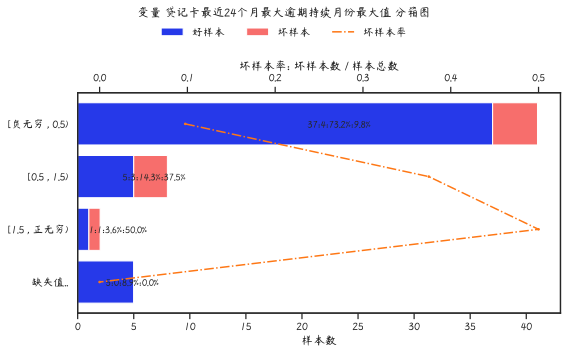

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,LIFT值
0,GEXDK_X2589,现用所有产品下未来6个月内到期的正常账户数,"[负无穷 , 0.5)",16,0.2857,15,0.3125,1,0.1250,0.0625,0.4375
1,GEXDK_X2589,现用所有产品下未来6个月内到期的正常账户数,"[0.5 , 1.5)",13,0.2321,12,0.2500,1,0.1250,0.0769,0.5385
2,GEXDK_X2589,现用所有产品下未来6个月内到期的正常账户数,"[1.5 , 5.5)",25,0.4464,20,0.4167,5,0.6250,0.2000,1.4000
3,GEXDK_X2589,现用所有产品下未来6个月内到期的正常账户数,"[5.5 , 正无穷)",2,0.0357,1,0.0208,1,0.1250,0.5000,3.5000


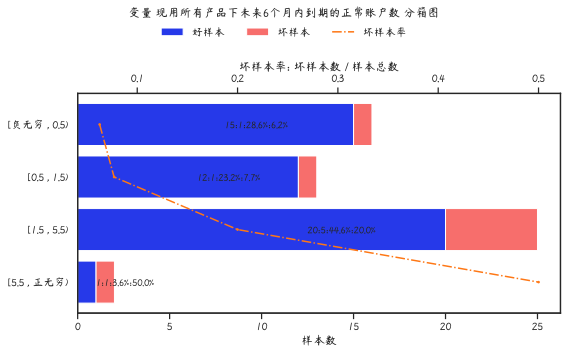

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,LIFT值
0,GEXDK_X2277,D1银行消费贷款期数大等于12的笔数除以D1银行消费贷笔数,"[负无穷 , 0.999998152256012)",52,0.9286,46,0.9583,6,0.7500,0.1154,0.8077
1,GEXDK_X2277,D1银行消费贷款期数大等于12的笔数除以D1银行消费贷笔数,"[0.999998152256012 , 正无穷)",4,0.0714,2,0.0417,2,0.2500,0.5000,3.5000


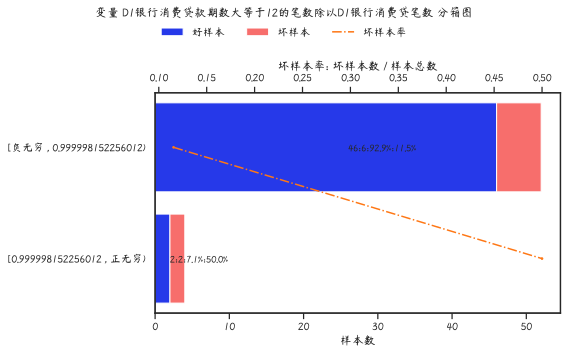

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,LIFT值
0,GEXDJK_X916,贷记卡最近6个月逾期总月份最大值,"[负无穷 , 1.0)",47.0000,0.8393,41.0000,0.8542,6.0000,0.7500,0.1277,0.8936
1,GEXDJK_X916,贷记卡最近6个月逾期总月份最大值,"[1.0 , 正无穷)",4.0000,0.0714,2.0000,0.0417,2.0000,0.2500,0.5000,3.5000
2,GEXDJK_X916,贷记卡最近6个月逾期总月份最大值,缺失值,5.0000,0.0893,5.0000,0.1042,0.0000,0.0000,0.0000,0.0000


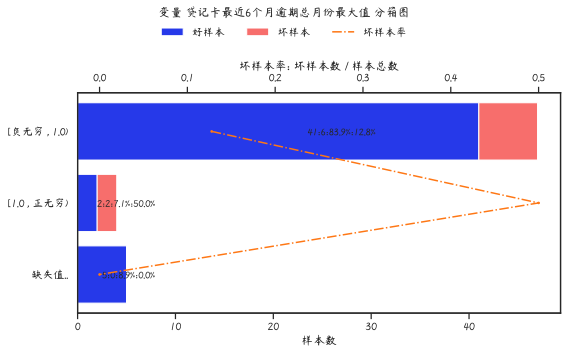

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,LIFT值
0,GEXJH_X108,过去60个月贷款贷记卡和准贷记卡持续逾期期数最大值,"[负无穷 , 0.5)",32,0.5714,29,0.6042,3,0.3750,0.0938,0.6562
1,GEXJH_X108,过去60个月贷款贷记卡和准贷记卡持续逾期期数最大值,"[0.5 , 2.5)",19,0.3393,16,0.3333,3,0.3750,0.1579,1.1053
2,GEXJH_X108,过去60个月贷款贷记卡和准贷记卡持续逾期期数最大值,"[2.5 , 3.5)",3,0.0536,2,0.0417,1,0.1250,0.3333,2.3333
3,GEXJH_X108,过去60个月贷款贷记卡和准贷记卡持续逾期期数最大值,"[3.5 , 正无穷)",2,0.0357,1,0.0208,1,0.1250,0.5000,3.5000


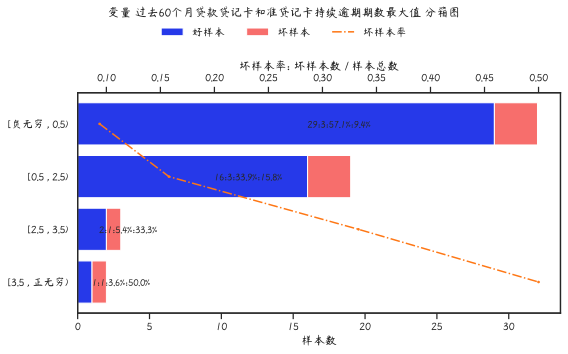

In [27]:
all_cols = list(combiner.rules.keys())
for col in all_cols:
    feature_table = feature_bin_stats(train, col, target=target, desc=feature_map.get(col, ""), combiner=combiner, ks=True)
    if len(feature_table[(feature_table["LIFT值"] > 3) & (feature_table["样本占比"] < 0.1)]):
        if len(feature_table) < 6:
            bin_plot(feature_table, feature=col, desc=feature_map.get(col, ""), colors=["#2639E9", "#F76E6C", '#FE7715'], max_len=20, figsize=(8, 5), save=f"model_report/bin_plots/data_{col}.png")
            display(feature_table[['指标名称', "指标含义", '分箱', '样本总数', '样本占比', '好样本数', '好样本占比', '坏样本数', '坏样本占比', '坏样本率', 'LIFT值']])
            plt.show()

//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


,组合策略,好样本数,好样本占比,坏样本数,坏样本占比,命中数,命中率,坏率,样本整体坏率,LIFT值
3,贷款近12个月最大逾期金额 > 470.5 & 近12月出现M1次数 > 1.5,0,0.0000,5,0.6250,5,0.0893,1.0000,0.1429,7.0000


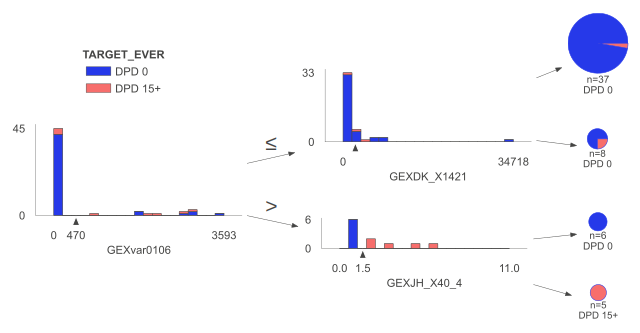

------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


,组合策略,好样本数,好样本占比,坏样本数,坏样本占比,命中数,命中率,坏率,样本整体坏率,LIFT值
3,贷款近12个月最大逾期金额 > 470.5 & 最近五年逾期透支贷记卡账户单月最长逾期透支月数 > 0.0,0,0.0000,5,0.6250,5,0.0893,1.0000,0.1429,7.0000


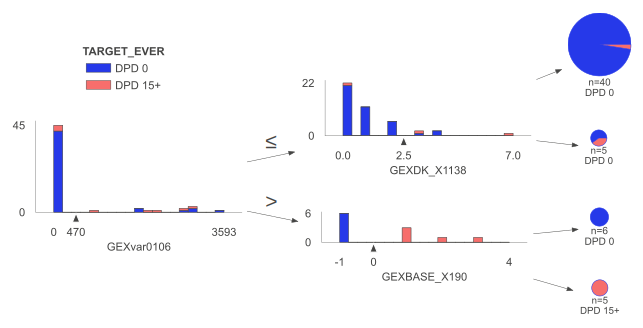

------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


,组合策略,好样本数,好样本占比,坏样本数,坏样本占比,命中数,命中率,坏率,样本整体坏率,LIFT值
3,贷记卡最近24个月逾期总月份最大值 > 0.5 & 现用消费贷本金余额求和占现用消费贷本金求和比率 <= 0.889,2,0.0417,3,0.3750,5,0.0893,0.6000,0.1429,4.2000


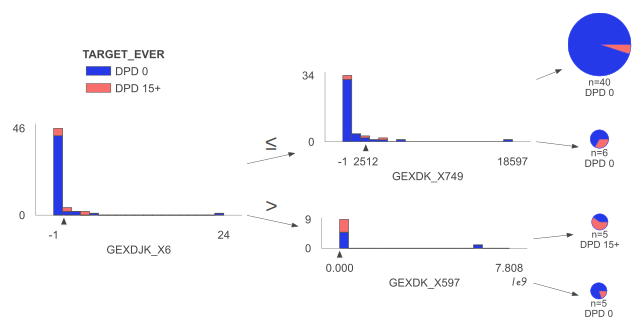

------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


,组合策略,好样本数,好样本占比,坏样本数,坏样本占比,命中数,命中率,坏率,样本整体坏率,LIFT值
3,过去60个月贷款贷记卡和准贷记卡持续逾期期数最大值 > 1.5 & 过去60个月贷款贷记卡和准贷记卡的最大逾期金额 <= 5982.5,1,0.0208,4,0.5000,5,0.0893,0.8000,0.1429,5.6000


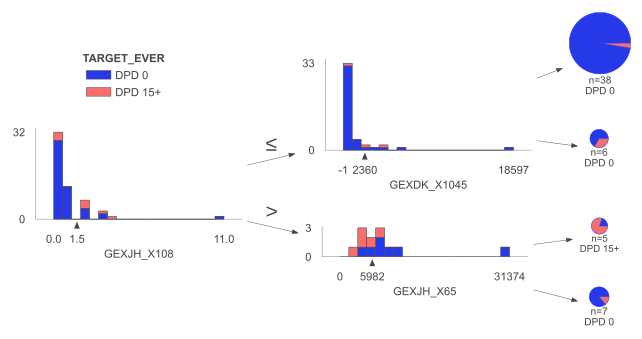

------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


,组合策略,好样本数,好样本占比,坏样本数,坏样本占比,命中数,命中率,坏率,样本整体坏率,LIFT值
2,现用无逾期有担保贷款本金余额求和 <= 25518.0,2,0.0417,3,0.3750,5,0.0893,0.6000,0.1429,4.2000


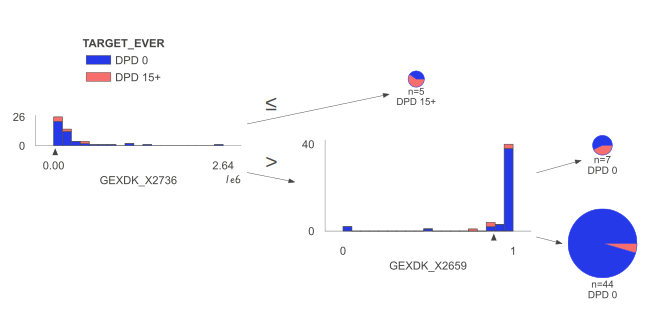

------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


,组合策略,好样本数,好样本占比,坏样本数,坏样本占比,命中数,命中率,坏率,样本整体坏率,LIFT值
2,现用消费贷发放金额小于1万元笔数除以现用总消费贷笔数 > 0.367 & 贷记卡最近12个月最大逾期持续月份最大值 > 0.5,1,0.0208,4,0.5000,5,0.0893,0.8000,0.1429,5.6000


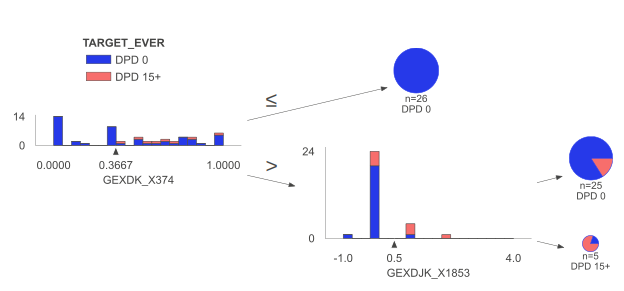

------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


,组合策略,好样本数,好样本占比,坏样本数,坏样本占比,命中数,命中率,坏率,样本整体坏率,LIFT值
3,贷款近12个月最大逾期金额 > 470.5 & 现用最近3个月无逾期消费贷本月实还款求和 <= 5246.0,1,0.0208,4,0.5000,5,0.0893,0.8000,0.1429,5.6000


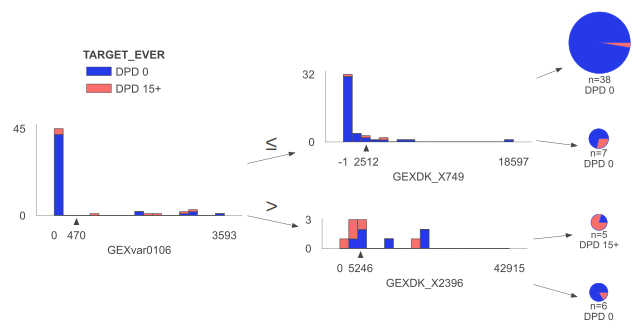

------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


,组合策略,好样本数,好样本占比,坏样本数,坏样本占比,命中数,命中率,坏率,样本整体坏率,LIFT值
3,过去60个月贷款贷记卡和准贷记卡持续逾期期数最大值 > 1.5 & 现用贷款未来十二个月每月平均应还款金额除以未来三个月 <= 0.954,1,0.0208,4,0.5000,5,0.0893,0.8000,0.1429,5.6000


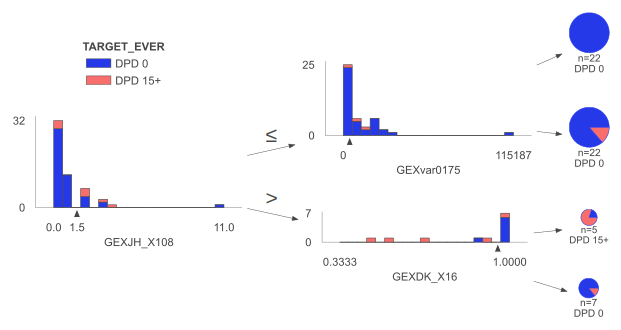

------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


,组合策略,好样本数,好样本占比,坏样本数,坏样本占比,命中数,命中率,坏率,样本整体坏率,LIFT值
2,现行贷记卡授信额度求和与现行贷记卡已用额度求和的比率 > 1.168 & 现用消费贷未来十二个月每月平均应还款金额除以未来三个月 <= 0.728,0,0.0000,5,0.6250,5,0.0893,1.0000,0.1429,7.0000


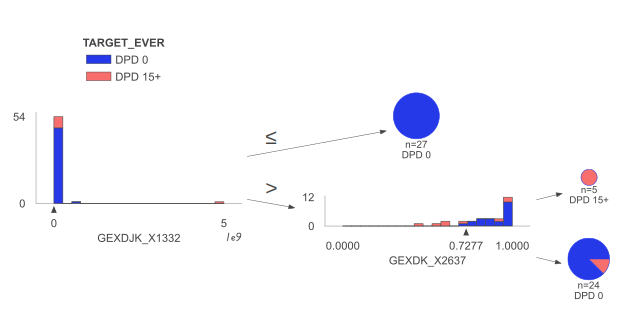

------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


,组合策略,好样本数,好样本占比,坏样本数,坏样本占比,命中数,命中率,坏率,样本整体坏率,LIFT值
2,现用无逾期贷款本金最大不包括房贷与汽车贷款 <= 162000.0 & 现用无逾期个人消费贷款本金余额最大 > 82131.5,2,0.0417,3,0.3750,5,0.0893,0.6000,0.1429,4.2000


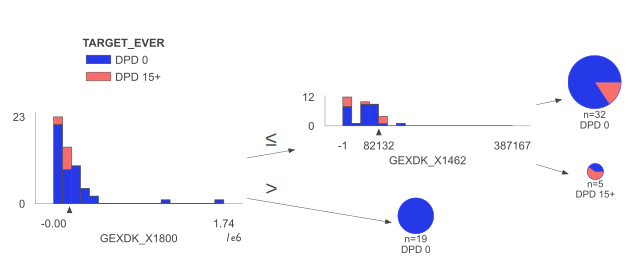

------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


,组合策略,好样本数,好样本占比,坏样本数,坏样本占比,命中数,命中率,坏率,样本整体坏率,LIFT值
3,贷记卡最近24个月最大逾期持续月份最大值 > 0.5 & 过去12个月贷款贷记卡和准贷记卡账户的最高逾期金额 > 1424.5,1,0.0208,4,0.5000,5,0.0893,0.8000,0.1429,5.6000


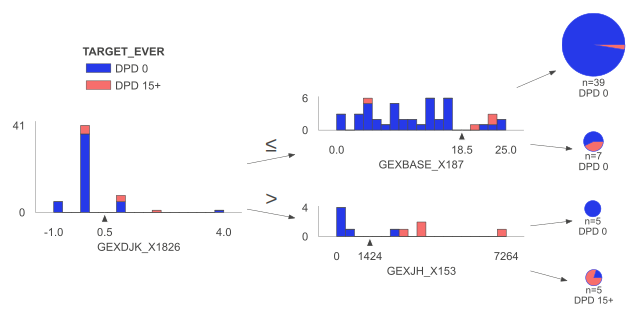

------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


,组合策略,好样本数,好样本占比,坏样本数,坏样本占比,命中数,命中率,坏率,样本整体坏率,LIFT值
3,最近五年逾期透支贷记卡账户月份数 > 0.0 & 现用所有产品下未来3个月内到期的正常账户本金余额之和 > 12.5,1,0.0208,4,0.5000,5,0.0893,0.8000,0.1429,5.6000


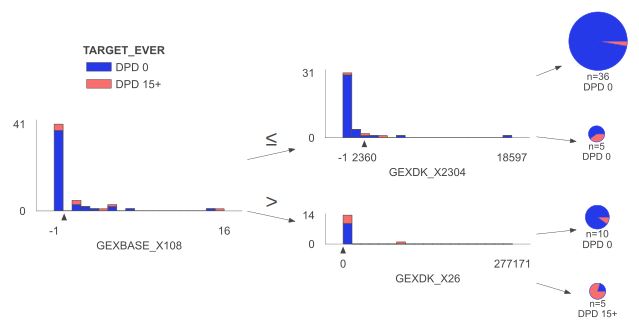

------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


,组合策略,好样本数,好样本占比,坏样本数,坏样本占比,命中数,命中率,坏率,样本整体坏率,LIFT值
3,现用贷款未来十二个月每月平均应还款金额除以未来六个月 <= 0.78 & 现行贷记卡授信额度求和与现行贷记卡已用额度求和的比率 > 1.376,1,0.0208,4,0.5000,5,0.0893,0.8000,0.1429,5.6000


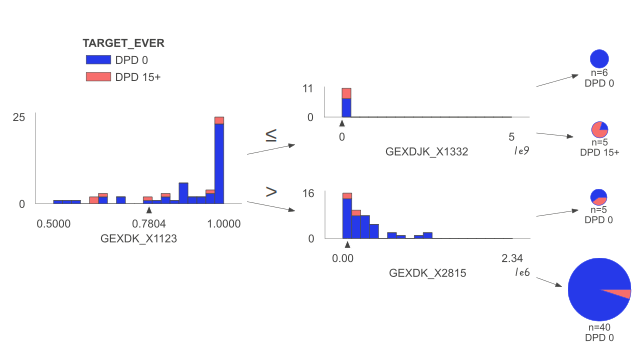

------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


,组合策略,好样本数,好样本占比,坏样本数,坏样本占比,命中数,命中率,坏率,样本整体坏率,LIFT值
3,现用贷款未来三个月每月平均应还款金额除以未来一个月 <= 0.995 & 现用无逾期个人消费贷款本金余额求和 <= 73814.0,2,0.0417,3,0.3750,5,0.0893,0.6000,0.1429,4.2000


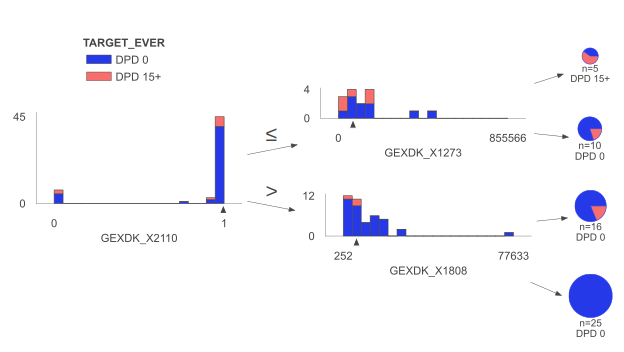

------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


,组合策略,好样本数,好样本占比,坏样本数,坏样本占比,命中数,命中率,坏率,样本整体坏率,LIFT值
3,最近12个月轻度逾期个人消费贷款账户数 > 0.5 & 现用消费贷本金余额求和占现用消费贷本金求和比率 <= 0.823,1,0.0208,4,0.5000,5,0.0893,0.8000,0.1429,5.6000


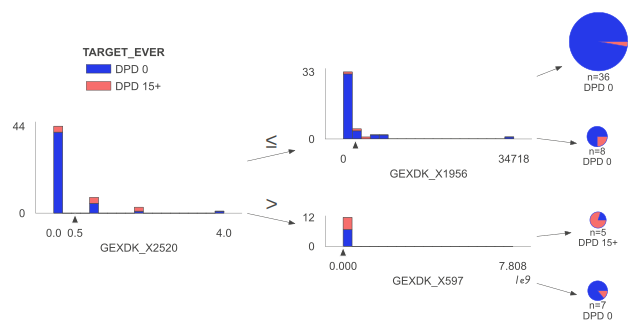

------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


,组合策略,好样本数,好样本占比,坏样本数,坏样本占比,命中数,命中率,坏率,样本整体坏率,LIFT值
2,婚姻状况 > 0.165 & 所有贷款账户最大最新还款记录中还款日期与应还款日期的差 > 47.5,2,0.0417,3,0.3750,5,0.0893,0.6000,0.1429,4.2000


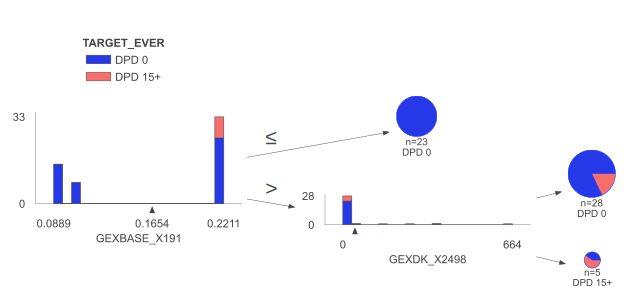

------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////


,组合策略,好样本数,好样本占比,坏样本数,坏样本占比,命中数,命中率,坏率,样本整体坏率,LIFT值
3,贷记卡最近24个月最大逾期持续月份最大值 > 0.5 & 个人消费贷款本金求和 > 153128.0,2,0.0417,3,0.3750,5,0.0893,0.6000,0.1429,4.2000


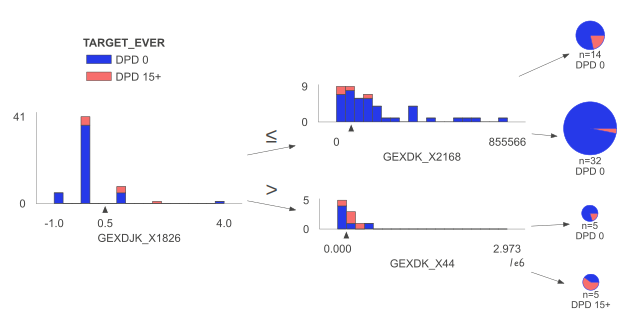

------------------------------------------------------------------------------------------------------------------------------------------------------


,组合策略,好样本数,好样本占比,坏样本数,坏样本占比,命中数,命中率,坏率,样本整体坏率,LIFT值
0,贷款近12个月最大逾期金额 > 470.5 & 近12月出现M1次数 > 1.5,0,0.0000,5,0.6250,5,0.0893,1.0000,0.1429,7.0000
1,贷款近12个月最大逾期金额 > 470.5 & 最近五年逾期透支贷记卡账户单月最长逾期透支月数 > 0.0,0,0.0000,5,0.6250,5,0.0893,1.0000,0.1429,7.0000
8,现行贷记卡授信额度求和与现行贷记卡已用额度求和的比率 > 1.168 & 现用消费贷未来十二个月每月平均应还款金额除以未来三个月 <= 0.728,0,0.0000,5,0.6250,5,0.0893,1.0000,0.1429,7.0000
3,过去60个月贷款贷记卡和准贷记卡持续逾期期数最大值 > 1.5 & 过去60个月贷款贷记卡和准贷记卡的最大逾期金额 <= 5982.5,1,0.0208,4,0.5000,5,0.0893,0.8000,0.1429,5.6000
5,现用消费贷发放金额小于1万元笔数除以现用总消费贷笔数 > 0.367 & 贷记卡最近12个月最大逾期持续月份最大值 > 0.5,1,0.0208,4,0.5000,5,0.0893,0.8000,0.1429,5.6000
6,贷款近12个月最大逾期金额 > 470.5 & 现用最近3个月无逾期消费贷本月实还款求和 <= 5246.0,1,0.0208,4,0.5000,5,0.0893,0.8000,0.1429,5.6000
7,过去60个月贷款贷记卡和准贷记卡持续逾期期数最大值 > 1.5 & 现用贷款未来十二个月每月平均应还款金额除以未来三个月 <= 0.954,1,0.0208,4,0.5000,5,0.0893,0.8000,0.1429,5.6000
10,贷记卡最近24个月最大逾期持续月份最大值 > 0.5 & 过去12个月贷款贷记卡和准贷记卡账户的最高逾期金额 > 1424.5,1,0.0208,4,0.5000,5,0.0893,0.8000,0.1429,5.6000
11,最近五年逾期透支贷记卡账户月份数 > 0.0 & 现用所有产品下未来3个月内到期的正常账户本金余额之和 > 12.5,1,0.0208,4,0.5000,5,0.0893,0.8000,0.1429,5.6000
12,现用贷款未来十二个月每月平均应还款金额除以未来六个月 <= 0.78 & 现行贷记卡授信额度求和与现行贷记卡已用额度求和的比率 > 1.376,1,0.0208,4,0.5000,5,0.0893,0.8000,0.1429,5.6000


In [63]:
removes = []
dt_rules = pd.DataFrame()

cat_features = list(set(train.select_dtypes(include=[object, pd.CategoricalDtype]).columns) - set([target]))
cat_features_index = [i for i, f in enumerate(train.columns) if f in cat_features]
X = train.drop(columns=[target])
y = train[target]

target_enc = ce.TargetEncoder(cols=cat_features)
target_enc.fit(X[cat_features], y)

X_TE = X.join(target_enc.transform(X[cat_features]).add_suffix('_target'))

target_enc.target_mapping = {}
for col in cat_features:
    mapping = X_TE[[col, f"{col}_target"]].drop_duplicates()
    target_enc.target_mapping[col] = dict(zip(mapping[col], mapping[f"{col}_target"]))

X_TE = X_TE.drop(columns=cat_features)
X_TE = X_TE.rename(columns={f"{c}_target": c for c in cat_features})
X_TE = X_TE.fillna(-1.0)

for i in range(128):
    decision_tree = DecisionTreeClassifier(max_depth=2, min_samples_split=8, min_samples_leaf=5, max_features="auto")
    decision_tree = decision_tree.fit(X_TE, y)
    
    if decision_tree.score(X_TE, y) < 0.8:
        break
    
    rules = get_dt_rules(decision_tree, X_TE.columns, sum(y) / len(y), len(y))
    viz_model = dtreeviz.model(decision_tree,
                               X_train=X_TE, y_train=y,
                               feature_names=X_TE.columns,
                               target_name=target, class_names=["DPD 0", f"DPD {dpd}+"])

    rules = rules.query("LIFT值 > 4 & 命中率 < 0.1")

    if len(rules) > 0:
        print("/" * 150)
        rules["组合策略"] = rules["组合策略"].replace(feature_map, regex=True)
        display(rules)
        c = viz_model.view(
            scale=1.5, 
            orientation='LR', 
            colors={
                    "classes": [None, None, ["#2639E9", "#F76E6C"], ["#2639E9", "#F76E6C", "#FE7715", "#FFFFFF"]],
                    "arrow": "#2639E9",
                    'text_wedge': "#F76E6C",
                    "pie": "#2639E9",
                    "tile_alpha": 1,
                    "legend_edge": "#FFFFFF",
                },
            ticks_fontsize=10,
            label_fontsize=10,
        )
        display(c)

        dt_rules = pd.concat([dt_rules, rules]).reset_index(drop=True)
        removes.append(decision_tree.feature_names_in_[list(decision_tree.feature_importances_).index(max(decision_tree.feature_importances_))])
        X_TE = X_TE.drop(columns=removes[-1])
        print("-" * 150)

pd.set_option('display.max_row', None)
dt_rules.sort_values(["LIFT值", "命中率"], ascending=False)